In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as io
import scipy.optimize as opt
from scipy import interpolate
from scipy.interpolate import UnivariateSpline


[ -3.76608759e-05   5.04978224e-02   5.85217070e+01]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


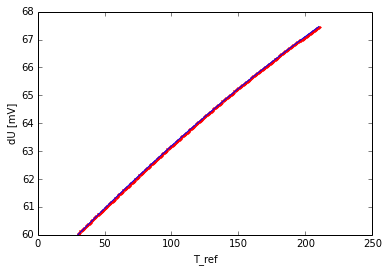

In [20]:
# data from type_E_sensor.pdf
filename = '/home/argo/masterarbeit/type_e_table_0_210_degC_raw.txt'

data = open(filename)

data_str = data.read()
data_str = data_str.replace('\n', ' ')
data = np.array(data_str.split(), dtype=float)[1:]
data = data[np.logical_not(np.mod(data, 10) == 0)]
data = np.concatenate(([0.], data))

seen = set()
U = np.array([x for x in data if not (x in seen or seen.add(x))])
U *= 1e3  # mV -> uV (microvolt)

T = range(len(U))
k = U / T

#plt.plot(T[30:], k[30:], '.')
#plt.plot(T, U, '.')

deg = 2
coeffs_fit = np.polyfit(T[30:], k[30:], deg)
print coeffs_fit



fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(T[30:], k[30:], '.', color='red', linewidth=0.1)
ax.plot(T[30:], np.polyval(coeffs_fit, T[30:]))
ax.set_xlabel('T_ref')
ax.set_ylabel('dU [mV]')


In [ ]:
l = data.read().split